In [1]:
import os
print(os.getcwd())

/home/monarch/workspace/ssc-assistant/app/api


In [2]:
from azure.identity import DefaultAzureCredential
import dotenv

# from src.repository.conversation_repository import ConversationRepository
from src.repository.conversation_repository import ConversationRepository

dotenv.load_dotenv()

True

In [3]:
from datetime import datetime
from typing import override
import os

from azure.data.tables import TableServiceClient

import json
from src.dao.chat_table_dao import ChatTableDaoImpl
from src.entity.table_row_entity import (
    ChatTableRow,
)

# get dir of this file

dir_path = os.getcwd()


class DiskCachingChatTableDaoImpl(ChatTableDaoImpl):
    """
    This class is a ChatTableDaoImpl that caches the results of the `all` method to disk
    in a JSON file. This is useful for development purposes, as it allows us to avoid
    making repeated requests to the Azure Table Storage service.
    """

    def __init__(
        self,
        table_service_client: TableServiceClient,
        # but from dir of this file
        cache_filepath: str = os.path.join(
            dir_path, "./.cache/chat_table_cache.global.json"
        ),
    ):
        super().__init__(table_service_client)
        self.cache: list[ChatTableRow] = []
        self.cache_filepath = cache_filepath

    @override
    def all(self) -> list[ChatTableRow]:
        # try and get pickle
        if len(self.cache) == 0:
            try:
                # create path if not exist
                os.makedirs(os.path.dirname(self.cache_filepath), exist_ok=True)
                with open(self.cache_filepath, "r") as f:
                    json_content = json.load(f)
                    # convert all timestamps to datetime
                    for row in json_content:
                        timestamp_str = row["metadata"]["timestamp"]
                        if timestamp_str is not None:
                            row["metadata"]["timestamp"] = datetime.fromisoformat(
                                timestamp_str
                            )
                    self.cache = json_content
            except FileNotFoundError:
                self.cache = []

        # if cache is still empty, get from super
        if len(self.cache) == 0:
            self.cache = super().all()
            # also save to disk.
            with open(self.cache_filepath, "w") as f:
                # json.dump(self.cache, f)
                json.dump(
                    self.cache,
                    f,
                    default=lambda o: o.isoformat()
                    if isinstance(o, datetime)
                    else o.__dict__,
                )

        return self.cache


In [4]:

# Get conversations
from src.service.stats_report_service import StatsReportService


credential = DefaultAzureCredential()
table_service_client = TableServiceClient(endpoint=os.getenv("DATABASE_ENDPOINT") or "", credential=credential)
chat_table_dao = DiskCachingChatTableDaoImpl(table_service_client)
conversation_repo = ConversationRepository(chat_table_dao)
conversations = conversation_repo.list_conversations()
stats_reporting_service = StatsReportService(conversation_repo)

In [5]:
report = stats_reporting_service.get_statistics_by_month_of_year()
print(report)

headers = ["Month", "Active users", "Total Questions Asked", "Average questions asked per day", "Average questions per user"]
header_format = "{:<15} {:<15} {:<25} {:<35} {:<25}"
row_format = "{:<15} {:<15} {:<25} {:<35} {:<25}"

print(header_format.format(*headers))

for stats in report:
    month = stats["month_label"]
    print(row_format.format(
        month, 
        stats["active_users"],
        stats["total_questions_asked"],
        stats["average_questions_asked_per_day"],
        stats["average_questions_per_user"])
    )

[{'month_label': 'May 2024', 'month_start_iso_date': '2024-05-01T00:00:00Z', 'month_end_iso_date': '2024-05-31T23:59:59Z', 'active_users': 2275, 'total_questions_asked': 11667, 'average_questions_asked_per_day': 376.35, 'average_questions_per_user': 5.13}, {'month_label': 'Jun 2024', 'month_start_iso_date': '2024-06-01T00:00:00Z', 'month_end_iso_date': '2024-06-30T23:59:59Z', 'active_users': 962, 'total_questions_asked': 5682, 'average_questions_asked_per_day': 189.4, 'average_questions_per_user': 5.91}, {'month_label': 'Jul 2024', 'month_start_iso_date': '2024-07-01T00:00:00Z', 'month_end_iso_date': '2024-07-31T23:59:59Z', 'active_users': 655, 'total_questions_asked': 4201, 'average_questions_asked_per_day': 135.52, 'average_questions_per_user': 6.41}, {'month_label': 'Aug 2024', 'month_start_iso_date': '2024-08-01T00:00:00Z', 'month_end_iso_date': '2024-08-31T23:59:59Z', 'active_users': 601, 'total_questions_asked': 4777, 'average_questions_asked_per_day': 154.1, 'average_questions_p

In [6]:
import pandas as pd
df = pd.DataFrame.from_records(stats_reporting_service.get_top_users_past_90_days())
df

# stats

df.to_csv("top_users_past_90_days.csv", index=False)

In [7]:
# Statistics by day of month

headers = ["Day of month", "Total Questions Asked", "Average questions per user"]
header_format = "{:<15} {:<25} {:<25}"
row_format = "{:<15} {:<25} {:<25}"

print(header_format.format(*headers))

date_ranges = [
            ("May 2024", "2024-05-01T00:00:00Z", "2024-05-31T23:59:59Z"),
            ("Jun 2024", "2024-06-01T00:00:00Z", "2024-06-30T23:59:59Z"),
            ("Jul 2024", "2024-07-01T00:00:00Z", "2024-07-31T23:59:59Z"),
            ("Aug 2024", "2024-08-01T00:00:00Z", "2024-08-31T23:59:59Z"),
            ("Sep 2024", "2024-09-01T00:00:00Z", "2024-09-30T23:59:59Z"),
            ("Oct 2024", "2024-10-01T00:00:00Z", "2024-10-31T23:59:59Z"),
            ("Nov 2024", "2024-11-01T00:00:00Z", "2024-11-30T23:59:59Z"),
            ("Dec 2024", "2024-12-01T00:00:00Z", "2024-12-31T23:59:59Z"),
            ("Jan 2025", "2025-01-01T00:00:00Z", "2025-01-31T23:59:59Z"),
        ]

for day in range(1, 32):
    # Total questions asked
    total_questions_asked = 0
    for conversation in conversations:
        for message in conversation["messages"]:
            if message["sender"] == "user" and datetime.fromisoformat(message["created_at"]).day == day:
                total_questions_asked += 1

    # Average questions asked per day
    total_questions_asked = 0
    for conversation in conversations:
        for message in conversation["messages"]:
            if message["sender"] == "user" and datetime.fromisoformat(message["created_at"]).day == day:
                total_questions_asked += 1

    # Average questions per user
    total_questions_asked = 0
    for conversation in conversations:
        for message in conversation["messages"]:
            if message["sender"] == "user" and datetime.fromisoformat(message["created_at"]).day == day:
                total_questions_asked += 1
    
    average_questions_per_day = total_questions_asked / len(date_ranges)
    # average_questions_per_user = total_questions_asked / active_users_count if active_users_count > 0 else 0

    print(row_format.format(
        day,
        total_questions_asked,
        f"{average_questions_per_day:.2f}",
        # f"{average_questions_per_user:.2f}"
    ))

Day of month    Total Questions Asked     Average questions per user
1               1199                      133.22                   
2               1589                      176.56                   
3               2215                      246.11                   
4               2171                      241.22                   
5               2149                      238.78                   
6               2329                      258.78                   
7               2002                      222.44                   
8               2279                      253.22                   
9               2045                      227.22                   
10              2408                      267.56                   
11              1905                      211.67                   
12              2161                      240.11                   
13              2812                      312.44                   
14              2903                      322.5

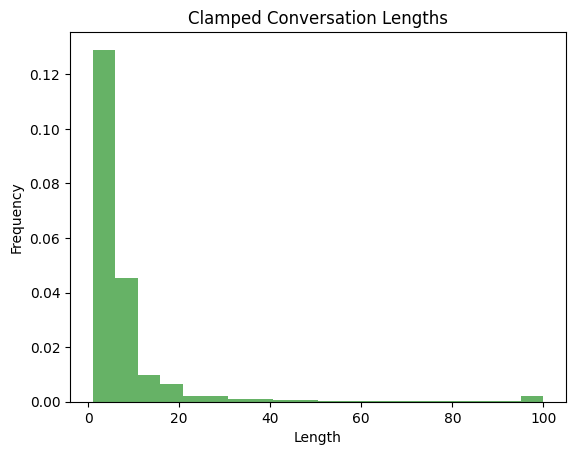

In [8]:
# Python
def get_conversation_lengths(self):
    conversations = self.conversation_repository.list_conversations()
    lengths = [len(c["messages"]) for c in conversations]
    clamped_lengths = [min(max(l, 0), 100) for l in lengths]  # Example clamp
    return clamped_lengths

# Python
import matplotlib.pyplot as plt
import numpy as np

def visualize_conversation_lengths(conversations):
    lengths = [len(conv["messages"]) for conv in conversations]
    clamped = [min(max(l, 0), 100) for l in lengths]

    plt.hist(clamped, bins=20, density=True, alpha=0.6, color='g')
    plt.title("Clamped Conversation Lengths")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.show()

# Python
visualize_conversation_lengths(conversations)

In [9]:
stats_reporting_service.get_monthly_user_engagement_report()

[{'month_label': 'May 2024',
  'month_start_iso_date': '2024-05-01T00:00:00Z',
  'month_end_iso_date': '2024-05-31T23:59:59Z',
  'active_users': 2275,
  'total_questions_asked': 11190,
  'average_questions_per_user': 4.92,
  'distribution_of_sessions_per_user': {'1': 1530,
   '2': 353,
   '3': 179,
   '4': 76,
   '5': 38,
   '6-10': 69,
   '11-20': 26,
   '21-50': 3,
   '51-100': 0,
   '100+': 1,
   'label_ordering': ['1',
    '2',
    '3',
    '4',
    '5',
    '6-10',
    '11-20',
    '21-50',
    '51-100',
    '100+']}},
 {'month_label': 'Jun 2024',
  'month_start_iso_date': '2024-06-01T00:00:00Z',
  'month_end_iso_date': '2024-06-30T23:59:59Z',
  'active_users': 962,
  'total_questions_asked': 5682,
  'average_questions_per_user': 5.91,
  'distribution_of_sessions_per_user': {'1': 600,
   '2': 151,
   '3': 85,
   '4': 36,
   '5': 29,
   '6-10': 36,
   '11-20': 21,
   '21-50': 4,
   '51-100': 0,
   '100+': 0,
   'label_ordering': ['1',
    '2',
    '3',
    '4',
    '5',
    '6-10',